Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
import os

notebook_path = os.getcwd()
print(notebook_path)

/home/tushar


### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
base_path = f'{notebook_path}/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(f"{base_path}/Train")
data_dir_test = pathlib.Path(f"{base_path}/Test")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'image_count_train={image_count_train}')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'image_count_test={image_count_test}')

image_count_train=2239
image_count_test=118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
SEED = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    seed=SEED,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=0.2,
    subset='training')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred',seed=SEED,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=0.2,
    subset='validation')

class_names = train_ds.class_names
print(class_names)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


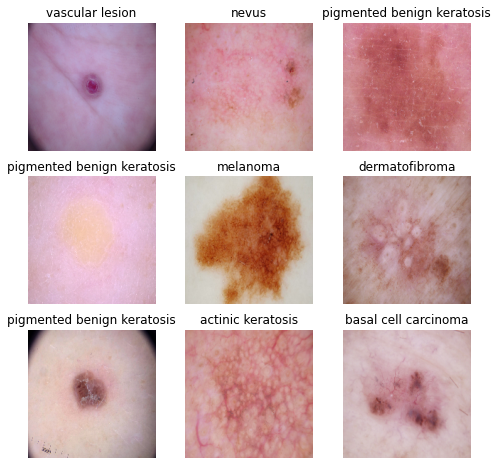

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for img, labl in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[labl[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [9]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0

### Train the model

In [11]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 65s 1s/step - loss: 2.1155 - accuracy: 0.2165 - val_loss: 1.9181 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 57s 1s/step - loss: 1.8899 - accuracy: 0.2946 - val_loss: 1.9252 - val_accuracy: 0.2595
Epoch 3/20
56/56 [==============================] - 51s 902ms/step - loss: 1.7780 - accuracy: 0.3538 - val_loss: 1.6254 - val_accuracy: 0.4318
Epoch 4/20
56/56 [==============================] - 49s 877ms/step - loss: 1.5857 - accuracy: 0.4403 - val_loss: 1.6177 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 50s 891ms/step - loss: 1.4453 - accuracy: 0.4911 - val_loss: 1.4105 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 46s 823ms/step - loss: 1.3183 - accuracy: 0.5296 - val_loss: 1.3839 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 46s 812ms/step - loss: 1.2712 - accuracy: 0.5368 - val_loss: 1.3968 - val_accuracy: 0.5302
Epoch

### Visualizing training results

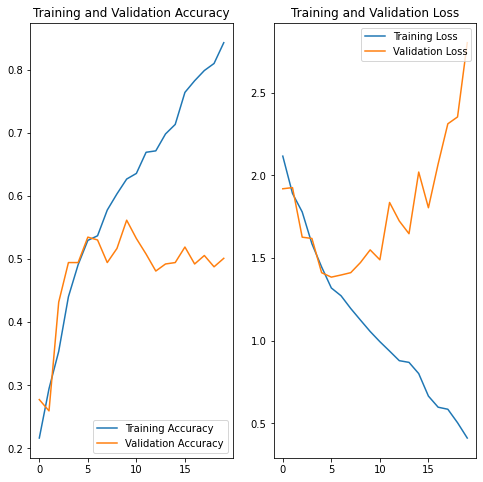

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
- Training Accuracy: The training accuracy steadily increases and reaches a plateau around 0.95.
- Validation Accuracy: The validation accuracy also increases initially but then plateaus at around 0.85.
- Training Loss: The training loss decreases significantly and levels off.
- Validation Loss: The validation loss decreases initially but starts to increase after a certain point.

Based on these observations, it appears that the model is overfitting to the training data. This is evident from the following:

The gap between training accuracy and validation accuracy is widening, indicating that the model is learning the training data too well and is not generalizing well to unseen data.
The validation loss starts to increase, suggesting that the model is making more errors on the validation set, further supporting the overfitting hypothesis.



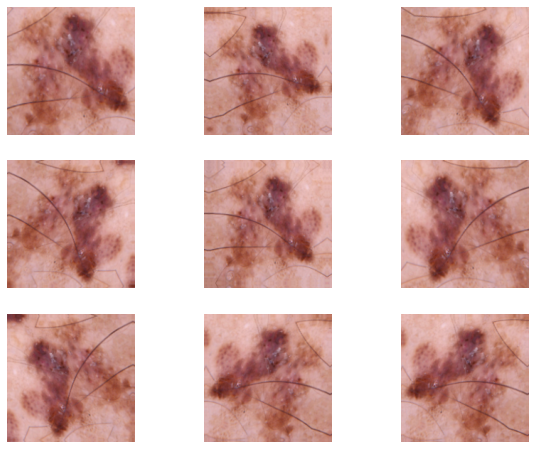

In [13]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [14]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  #added Dropout layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  #added Dropout layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  #added Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  #added Dropout layer
    layers.Dense(9, activation='softmax')
])


### Compiling the model

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 64)       

### Training the model

In [16]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 53s 908ms/step - loss: 2.2369 - accuracy: 0.1881 - val_loss: 2.0591 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 55s 977ms/step - loss: 1.9516 - accuracy: 0.2907 - val_loss: 1.8280 - val_accuracy: 0.4586
Epoch 3/20
56/56 [==============================] - 55s 987ms/step - loss: 1.7704 - accuracy: 0.3700 - val_loss: 1.6784 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 54s 968ms/step - loss: 1.6691 - accuracy: 0.4090 - val_loss: 1.5663 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 51s 907ms/step - loss: 1.6379 - accuracy: 0.4302 - val_loss: 1.4773 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 51s 915ms/step - loss: 1.5849 - accuracy: 0.4542 - val_loss: 1.4951 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 51s 903ms/step - loss: 1.5202 - accuracy: 0.4749 - val_loss: 1.4697 - val_accuracy: 0.5168

### Visualizing the results

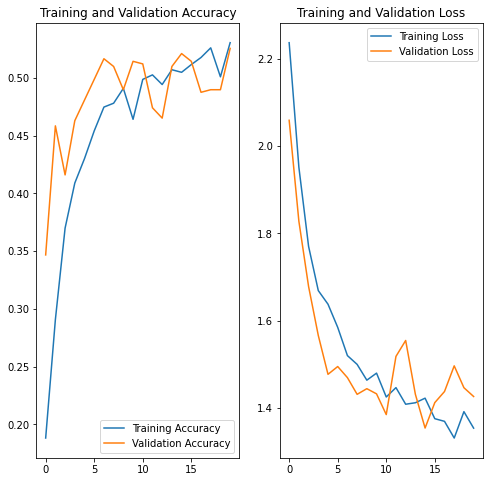

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training and Validation Accuracy
- Training Accuracy: Steadily increases and reaches a high plateau.
- Validation Accuracy: Increases initially but then plateaus at a lower level compared to training accuracy and shows signs of decline towards the end.

Training and Validation Loss
- Training Loss: Decreases significantly and levels off.
- Validation Loss: Decreases initially but then starts to increase, indicating the model is learning noise from the training data rather than generalizable patterns.

The gap between training and validation accuracy, as well as the increasing validation loss, strongly suggest that the model is memorizing the training data rather than learning underlying patterns.


#### Finding distribution of classes in the training dataset.


In [18]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [19]:
from glob import glob

path_list = glob(os.path.join(data_dir_train, '*', '*.jpg'))
lesion_list = [os.path.basename(os.path.dirname(path)) for path in path_list]

original_df = pd.DataFrame({'Path': path_list, 'Label': lesion_list})

class_distribution = original_df['Label'].value_counts()

print(class_distribution)

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64


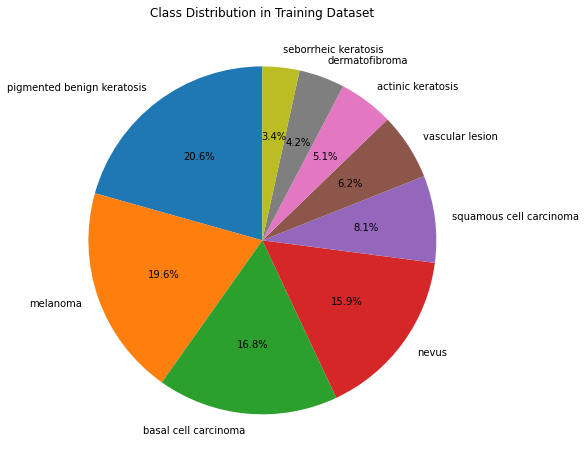

In [20]:
label_counts = original_df['Label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution in Training Dataset')
plt.show()


#### Findings 
- Which class has the least number of samples? - **seborrheic keratosis**
   
- Which classes dominate the data in terms proportionate number of samples? - **pigmented benign keratosis**

#### Rectifying the class imbalance


In [21]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [22]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F441CC893C8>: 100%|██████████| 500/500 [00:06<00:00, 78.32 Samples/s]                   


Initialised with 376 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F441DE46470>: 100%|██████████| 500/500 [00:04<00:00, 103.93 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F441DE57438>: 100%|██████████| 500/500 [00:04<00:00, 113.70 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F42FC1FF358>: 100%|██████████| 500/500 [00:14<00:00, 34.42 Samples/s]                     


Initialised with 357 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F430C60A7F0>: 100%|██████████| 500/500 [00:15<00:00, 33.31 Samples/s]                     


Initialised with 462 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F443CED6278>: 100%|██████████| 500/500 [00:04<00:00, 123.82 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F441CD877B8>: 100%|██████████| 500/500 [00:07<00:00, 69.67 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F42D8755BE0>: 100%|██████████| 500/500 [00:03<00:00, 149.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F430C649B00>: 100%|██████████| 500/500 [00:04<00:00, 101.23 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [23]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [24]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[0]

'/home/tushar/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_00d00e4b-51e3-4494-beab-f7167062f91f.jpg'

In [25]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0]

'actinic keratosis'

In [26]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [27]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [28]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [29]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [30]:
data_dir_train = pathlib.Path(f"{base_path}/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [31]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating final model

In [32]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  #added Dropout layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  #added Dropout layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  #added Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  #added Dropout layer
    layers.Dense(9, activation='softmax')
])


#### Compiling model

In [33]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 43, 64)       

#### Train model

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 50
earlystop = EarlyStopping(monitor="val_loss", patience=10, mode="auto",
                          verbose=1, min_delta=0.001, restore_best_weights=True)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy",
                             save_best_only=True, mode="auto", verbose=1)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[earlystop, checkpoint]
)

Epoch 1/50
169/169 [==============================] - 163s 958ms/step - loss: 2.1930 - accuracy: 0.1845 - val_loss: 1.9953 - val_accuracy: 0.2487

Epoch 00001: val_accuracy improved from -inf to 0.24870, saving model to model.keras
Epoch 2/50
169/169 [==============================] - 166s 978ms/step - loss: 1.9173 - accuracy: 0.2480 - val_loss: 1.8233 - val_accuracy: 0.3096

Epoch 00002: val_accuracy improved from 0.24870 to 0.30958, saving model to model.keras
Epoch 3/50
169/169 [==============================] - 160s 943ms/step - loss: 1.7082 - accuracy: 0.3489 - val_loss: 1.5754 - val_accuracy: 0.3920

Epoch 00003: val_accuracy improved from 0.30958 to 0.39198, saving model to model.keras
Epoch 4/50
169/169 [==============================] - 164s 971ms/step - loss: 1.5853 - accuracy: 0.3895 - val_loss: 1.4925 - val_accuracy: 0.4462

Epoch 00004: val_accuracy improved from 0.39198 to 0.44618, saving model to model.keras
Epoch 5/50
169/169 [==============================] - 164s 967m

####  Visualize the model results

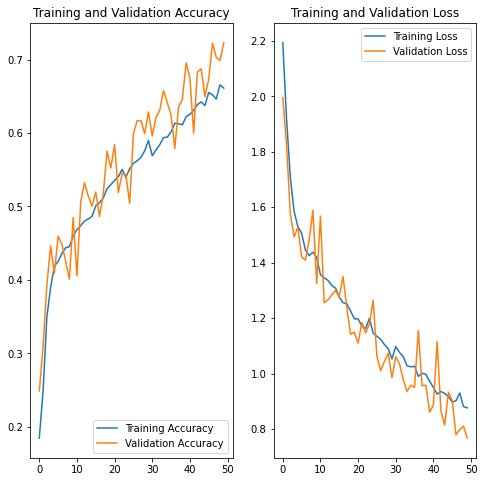

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing model on Test Data


In [36]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 118 files belonging to 9 classes.


In [38]:
loss , accuracy = model.evaluate(test_ds)

4/4 [==============================] - 2s 154ms/step - loss: 3.7239 - accuracy: 0.4831


**Accuracy:**

- Training Accuracy: The training accuracy steadily increases, reaching almost 0.75 (75%) by the end of the training period. This indicates that the model is learning to correctly classify the training data increasingly well.

- Validation Accuracy: The validation accuracy also shows an upward trend initially, but it plateaus around 0.55 (55%) and then starts to slightly decrease. This suggests that the model is starting to overfit to the training data, meaning it's memorizing the training examples rather than learning generalizable patterns.

**Loss:**

- Training Loss: The training loss consistently decreases, indicating that the model is making fewer errors on the training data as it learns.

- Validation Loss: The validation loss also decreases initially but then starts to increase after around 25 epochs. This confirms the overfitting behavior observed in the accuracy graph. The model is becoming less accurate on unseen data.

**Interpretation**

The graphs suggest that the model is overfitting to the training data. This is a common issue in machine learning, where the model becomes too specialized to the training set and performs poorly on new, unseen data.